In [1]:
# Установка pydicom
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.4 MB/s eta 0:00:00


In [2]:
# Инструменты для работы с изображениями
from tensorflow.keras.preprocessing import image

# Для работы с dcm-изображениями
import pydicom as dicom

# Для работы с nii-изображениями
import nibabel as nib

# Инструменты для работы с массивами
import numpy as np

# Для работы с файлами
import os

# Увеличение объёма оперативной памяти Colab
import resource
resource.setrlimit(resource.RLIMIT_DATA, (2**30, 2**31-1))

# очистка ОЗУ
import gc

# Игнорирование предупреждений
import warnings

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -qo /content/drive/MyDrive/Original -d data

Mounted at /content/drive


In [4]:
# Скачиваем архивы и распаковываем в папку data

!gdown -qO PleThora_Effusions_June_2020.zip https://wiki.cancerimagingarchive.net/download/attachments/68551327/PleThora%20Effusions%20June%202020.zip?version=1&modificationDate=1593202778373&api=v2
!unzip -qo PleThora_Effusions_June_2020 -d data

!gdown -qO PleThora_Thoracic_Cavities_June_2020.zip https://wiki.cancerimagingarchive.net/download/attachments/68551327/PleThora%20Thoracic_Cavities%20June%202020.zip?version=1&modificationDate=1593202695428&api=v2
!unzip -qo PleThora_Thoracic_Cavities_June_2020 -d data

#!gdown -q https://drive.google.com/uc?id=13Fm6vu45kkU8o85Lp2JVtItItIOJlovc
#!unzip -qo Original -d data
#!gdown -q https://drive.google.com/uc?id=1RaQCBTuKpRbjnyhro4TmrmmxJJa_jZHI
#!unzip -qo lungs1-5_Original -d data

In [5]:
# Глобальные параметры

IMG_RESOLUTION = 512                                            # Разрешение картинки
DATA_DIR = os.path.join(os.sep, 'content', 'data')              # Папка с данными
CLASS_COUNT = 2                                                 # Количество классов (с выпотом и без) 

# Получаем пути к папкам с оригинальными изображениями и плевральными масками
original_dir = os.path.join(DATA_DIR, 'Original')               # Папка с оригинальными DICOM файлами
effusions_dir = os.path.join(DATA_DIR, 'Effusions')             # Папка с файлами плевральных выпотов
thor_cav_dir = os.path.join(DATA_DIR, 'Thoracic_Cavities')      # Папка с файлами грудных полостей

Напишем функцию для формирования конечной папки с изображениями, будь то:
- LUNG1-XXX;
- LUNG1-XXX/какая-то_папка
- LUNG1-XXX/какая-то_папка1/какая-то_папка2

In [6]:
# Функция получения пути к папке с изображениями

def get_full_path(sub_path):  # sub_path - полный путь к папке LUNG1-XXX
    
    full_path = sub_path
    for _ in range(2):
        if os.path.isdir(full_path):
            full_path = os.path.join(full_path, os.listdir(full_path)[0])

    return full_path

In [7]:
# Функция получения списка исключительно папок в определённой директории

def get_folders(path):                        # путь к папке с данными

    # Создаём список, содержащий только папки
    folders = []
    for item in os.listdir(path):             # список элементов в директории
        full_path = os.path.join(path, item)
        if os.path.isdir(full_path):
            folders.append(item)

    return folders

Посмотрим картинки.

In [8]:
# Функция для отображения трёх картинок из разных наборов

def plot_all_sets(img1, img2, img3,
                  title1 = 'Оригинальное изображение',
                  title2 = 'Плевральный выпот',
                  title3 = 'Грудная полость'):

    plt.figure(1, figsize=(16, 10))
    plt.subplot(1, 3, 1)
    plt.title(title1, fontweight='bold')
    plt.imshow(img1, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(title2, fontweight='bold')
    plt.imshow(img2, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(title3, fontweight='bold')
    plt.imshow(img3, cmap='gray')
    plt.axis('off')

    plt.show()

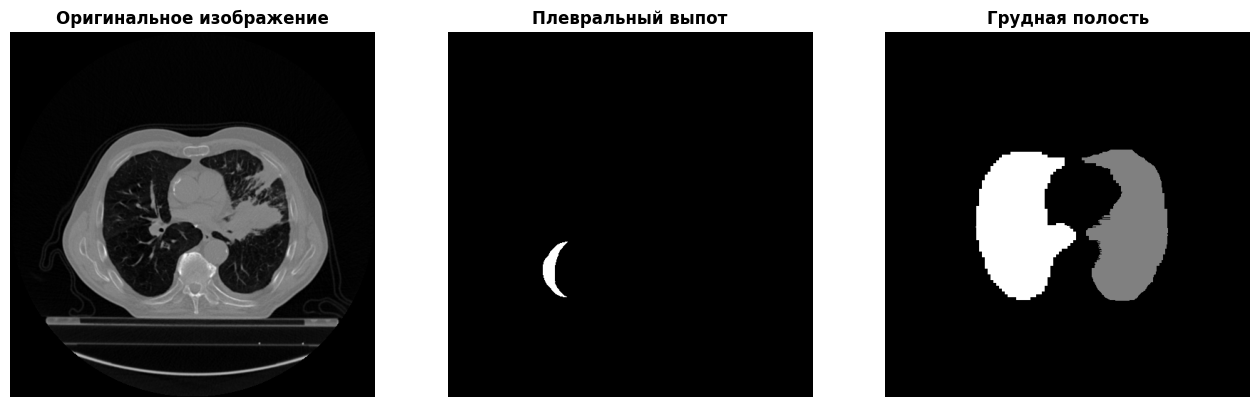

<class 'pydicom.dataset.FileDataset'> <class 'numpy.ndarray'> uint16 (512, 512)
<class 'nibabel.nifti1.Nifti1Image'> <class 'numpy.ndarray'> uint16 (512, 512)
<class 'nibabel.nifti1.Nifti1Image'> <class 'numpy.ndarray'> uint16 (512, 512)


In [16]:
img_slice = 64    # номер среза изображения
lung_num = 1      # номер папки с изображениями (параметр XXX в LUNG1-XXX)

# Определяем название папки
lung_folder = f'LUNG1-{str(lung_num).zfill(3)}'

# Оригинальное изображение в формате dcm
img_orig = dicom.dcmread(os.path.join(get_full_path(os.path.join(original_dir, lung_folder)),
                                      f'1-{str(img_slice).zfill(3)}.dcm'))
img_orig_np = img_orig.pixel_array

# Отключаем предупреждения - для метода .get_data()
warnings.filterwarnings('ignore')

# Маска плеврального выпота в формате nii
img_eff = nib.load(os.path.join(effusions_dir, lung_folder,
                                f'{lung_folder}_effusion_first_reviewer.nii.gz'))
#img_eff_np = img_eff.get_fdata(dtype=np.float16)
img_eff_np = img_eff.get_data()[:, :, img_slice]

# Маска плевральной грудной полости в формате nii
img_thor_cav = nib.load(os.path.join(thor_cav_dir, lung_folder,
                                     f'{lung_folder}_thor_cav_primary_reviewer.nii.gz'))
img_thor_cav_np = img_thor_cav.get_data()[:, :, img_slice]
warnings.filterwarnings('default')
# переворачиваем снимок
img_thor_cav_np = np.rot90(img_thor_cav_np)

# Рисуем
plot_all_sets(img_orig_np, img_eff_np, img_thor_cav_np)

# Выводим информацию о файлах
print(type(img_orig), type(img_orig_np), img_orig_np.dtype, img_orig_np.shape)
print(type(img_eff), type(img_eff_np), img_eff_np.dtype, img_eff_np.shape)
print(type(img_thor_cav), type(img_thor_cav_np), img_thor_cav_np.dtype, img_thor_cav_np.shape)

Посмотрим, что внутри файла dcm.

In [10]:
print(img_orig)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.32722.99.99.232169797615550376208184444154014090680
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.32722.99.99.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


С целью экономии памяти определим минимальное (`min_dcm`) и максимальное (`max_dcm`) значение пикселя в оригинальных картинках dcm для преобразования картинки в numpy-массив соответствующего типа.

Кроме того, проверим (`inst_num_f`) соответствие имени файла тегу Instance Number и определим максимальное количество срезов (`max_slices`) для  расширения 3D изображений недостающими срезами.

Также предполагая, что Pleural Effusion лежит в диапазоне от 0 до 400 HU, сформируем маски для этих пределов (`mask_hu`) и сравним с имеющимися масками (`mask_eff`). Для удобства выделим часть кода по этой теме в функции.

In [11]:
def getEffusionsMask():

    # Получаем срез маски, если удастся
    try:
        effusions_f = True
        nii_file = os.path.join(effusions_dir, lung_folder,                     # путь к маске с выпотом            
                                sorted(os.listdir(os.path.join(effusions_dir,
                                                              lung_folder)))[0])
        warnings.filterwarnings('ignore')
        mask_eff = nib.load(nii_file).get_data()[:, :, img_slice_num]
        warnings.filterwarnings('default')
        if np.sum(mask_eff)==0: effusions_f = False
    except:
        effusions_f = False
        mask_eff = None

    return effusions_f, mask_eff

def plot_slices():
    # Получаем картинку, приведённую к Hounsfield Units   
    image_hu = image_np * img_orig.RescaleSlope + img_orig.RescaleIntercept         

    # Формируем новую маску, предполагая, что выпот находится в пределах от min_eff_hu до max_eff_hu
    # в формате обычных пикселей за пределами маски, 0 - нет выпота, 1 - есть выпот
    mask = (image_hu >= min_eff_hu) & (image_hu <= max_eff_hu)  # создаем булевский массив с условием для маски
    image_hu[mask] = 1 - img_orig.RescaleIntercept              # присваиваем 1 элементам со значениями от min_eff_hu до max_eff_hu
    image_hu[~mask] = - img_orig.RescaleIntercept               # присваиваем 0 элементам, не удовлетворяющим условию
    
    # Переводим маску в формат пикселей изображения dcm
    mask_np = ((image_hu - img_orig.RescaleIntercept) // img_orig.RescaleSlope).astype(np.int8)

    # Рисуем картинки для сравнения
    print(lung_folder)
    plot_all_sets(image_np, mask_np, mask_eff, 'Оригинальное', 'Маска сформированная', 'Маска имеющаяся')

LUNG1-001


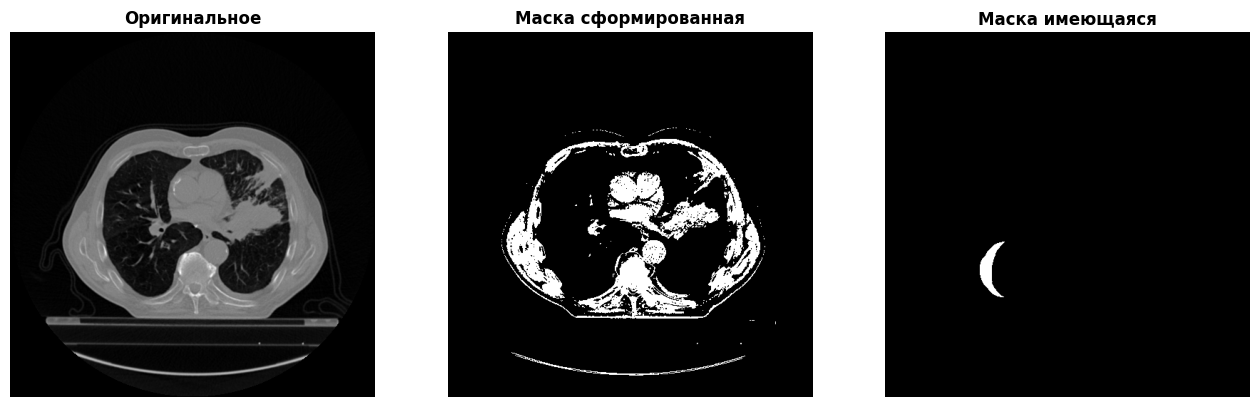

LUNG1-002


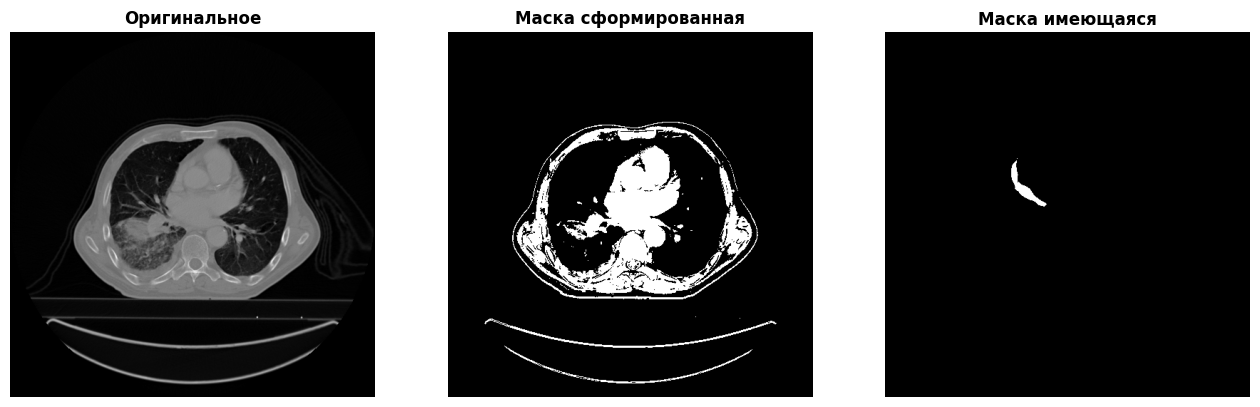

LUNG1-005


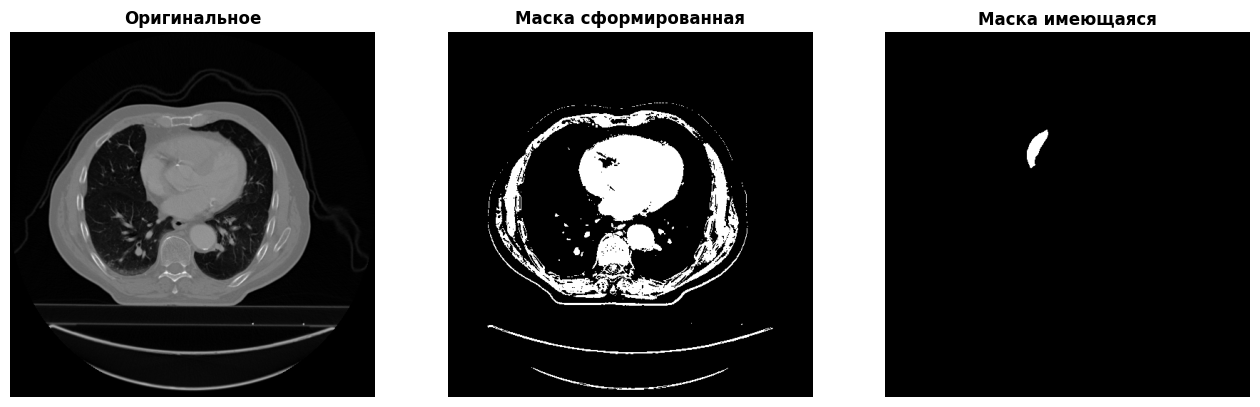

LUNG1-008


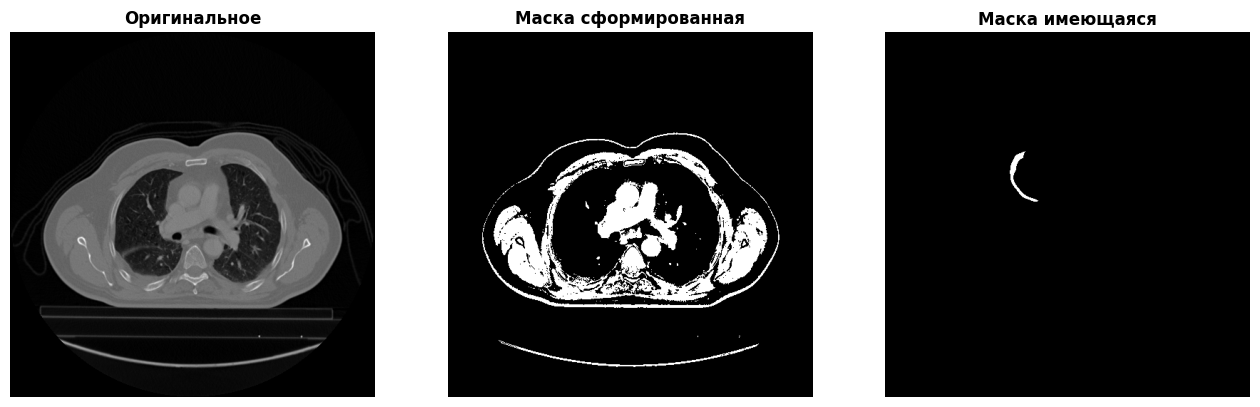

LUNG1-016


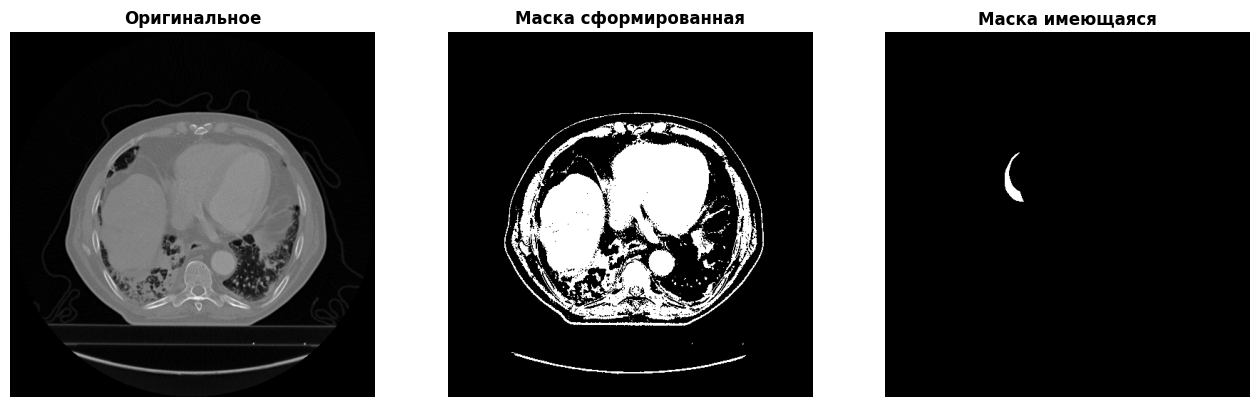

In [17]:
min_dcm = 0             # минимальное значение пикселей в изображении
max_dcm = 0             # максимальное значение пикселей в изображении
min_eff_hu = 0          # минимальное значение HU, где может быть выпот
max_eff_hu = 400        # максимально значение HU, где может быть выпот
effusions_count = 0     # количество рисунков с выпотами
img_slice_num = 64      # номер среза (от балды) для масок с выпотами
files_count = []                # количество файлов в папке LUNG1-XXX

# Предположим, что имена файлов соответствует тегам Instance Number, для чего включим флаг
inst_num_f = True

# Для всех директорий в каталоге по указанному пути:
for lung_folder in sorted(get_folders(original_dir)):

    full_path = get_full_path(os.path.join(original_dir, lung_folder))

    # Если есть маска для экземпляра - получаем её (если удаётся вместить в память)
    if effusions_count < 5:
        effusions_f, mask_eff = getEffusionsMask()
    else: effusions_f = False

    # Проходимся по всем изображениям в папке
    for file_name in sorted(os.listdir(full_path)):
        
        # Определяем количество файлов в папке
        files_count.append(len(os.listdir(full_path)))

        # Получаем представление снимка в виде датасета и цифры
        img_orig = dicom.dcmread(os.path.join(full_path, file_name))
        image_np = img_orig.pixel_array

        # Делаем проверку min, max
        min_pv = np.min(image_np)               # минимальное значение пикселей в изображении
        max_pv = np.max(image_np)               # максимальное значение пикселей в изображении 
        if min_dcm > min_pv: min_dcm = min_pv
        if max_dcm < max_pv: max_dcm = max_pv

        # Проверяем соответствие имени файла и тега Instance Number
        if int(img_orig.InstanceNumber) != int(file_name[file_name.index('-')+1:file_name.index('.')]) : inst_num_f = False

        # Если есь маска для оригинального файла, выведено менее 5 срезов, то для среза img_slice_num 
        if effusions_f and (str(img_slice_num) in file_name):
            plot_slices()
            effusions_count += 1

    gc.collect()

# Получаем максимально возможное количество срезов для работы сети без разбалансировки базы
max_slices = max(files_count)

In [19]:
# Смотрим полученные значения
print('min pixel value:', min_dcm)
print('max pixel value:', max_dcm)
print('Instance Number flag:', inst_num_f)
print('Максимальное количество срезов:', max_slices)

min pixel value: -1024
max pixel value: 4095
Instance Number flag: True
Максимальное количество срезов: 297


Видим, что значения пикселей лежат в пределах (-1024:4095) - можем использовать тип int16 для формирования данных и float16 для нормирования.

Названия файлов соответствуют тегу Instance Number, а значит будем придерживаться прямой последовательности при формировании массивов данных.

На сформированных масках видим, что часть данных оригинального изображения отсекается, но полученные маски далеки от имеющихся. Можем использовать предложенный диапазон значений выпотов в единицах HU только для увеличения точности путём отсечения излишних данных. 

Теперь посмотрим левые верхние пиксели на масках с выпотом и плевральной грудной полостью и сравним их с аналогичными пикселями на масках оригинальных изображений.

In [14]:
warnings.filterwarnings('ignore')

# маска1 - с плевральным выпотом
img_thor_cav = nib.load(os.path.join(thor_cav_dir, 'LUNG1-004', 'LUNG1-004_thor_cav_primary_reviewer.nii.gz'))
img_thor_cav_np = np.rot90(img_thor_cav.get_data()[:,:,0])
print(type(img_thor_cav), type(img_thor_cav_np), img_thor_cav_np.dtype, img_thor_cav_np.shape)

# маска2 - с плевральной грудной полостью
img_eff = nib.load(os.path.join(effusions_dir, 'LUNG1-005', 'LUNG1-005_effusion_first_reviewer.nii.gz'))
img_eff_np = img_eff.get_data()[:,:,0]
print(type(img_eff), type(img_eff_np), img_eff_np.dtype, img_eff_np.shape)

warnings.filterwarnings('default')

# оригинальное для сравнения с маской1
image_obj = dicom.dcmread(os.path.join(original_dir, 'LUNG1-004', '09-24-2006-StudyID-NA-27873',
                                       '0.000000-NA-20785', '1-001.dcm'))
image_np = image_obj.pixel_array
print(type(image_obj), type(image_np), image_np.dtype, image_np.shape)

# оригинальное для сравнения с маской2
image_obj2 = dicom.dcmread(os.path.join(original_dir, 'LUNG1-005', '01-01-2014-StudyID-NA-93819',
                                        '1.000000-NA-68747/1-01.dcm'))
image_np2 = image_obj.pixel_array
print(type(image_obj), type(image_np), image_np.dtype, image_np.shape)

# Значения пикселей
print(img_thor_cav_np[0, 0], image_np[0, 0])
print(img_eff_np[0, 0], image_np2[0, 0])

<class 'nibabel.nifti1.Nifti1Image'> <class 'numpy.ndarray'> uint16 (512, 512)
<class 'nibabel.nifti1.Nifti1Image'> <class 'numpy.ndarray'> uint16 (512, 512)
<class 'pydicom.dataset.FileDataset'> <class 'numpy.ndarray'> uint16 (512, 512)
<class 'pydicom.dataset.FileDataset'> <class 'numpy.ndarray'> uint16 (512, 512)
0 0
0 0


Из выполненного кода видим, что везде нули - ими и будем заполнять недостающие срезы dcm.